# Transaction Classification



## Challenge

For a given set of financial transactions, classify each one into one of seven revenue (transaction) categories. 
In this challenge, a "Multinomial Naive Bayes" classifier is trained  and fitted with the trasaction  word counts and class categori  values. The categories are
- Income
- Private (cash, deposit, donation, presents)
- Living (rent, additional flat expenses, ...)
- Standard of living (food, health, children, ...)
- Finance (credit, bank costs, insurances, savings)
- Traffic (public transport, gas stations, bike, car rent, ...)
- Leisure (hobby, sport, vacation, shopping, ...) 



## Aproach 
Implement a Generic Naive Bayes Classifier

1. Clean and prepare the given data
2. Label the data and store it
3. Define the features you want to use
4. Prepare your features / transform them into a format you can work with
5. Train your model
5. Evaluate your model
6. Visualize your results


In [81]:
# Load necessary libraries for data processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Imports for Classification 
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score


In [43]:
#Libraries for Natural LAnguage and Data cleaning 
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data

The first step is to load the data in a pandas Dataframe structure 
and have an some information about the dataset.

In [28]:
# Load the data as pandas Dataframe structure
data = pd.read_csv("SAKI Exercise 1 - Transaction Classification - Data Set.csv",sep=';',index_col=0, encoding='utf8',header=0)

# Print summary of the column names and Data types 
print(' Columns  \t \t \t Data Types\n' + 20*'---'+'\n', data.dtypes)

 Columns  	 	 	 Data Types
------------------------------------------------------------
 Auftragskonto                        float64
Buchungstag                           object
Valutadatum                           object
Buchungstext                          object
Verwendungszweck                      object
Beguenstigter/Zahlungspflichtiger     object
Kontonummer                           object
BLZ                                   object
Betrag                                object
Waehrung                              object
label                                 object
dtype: object


#### Data Exploration

In order to obtain a better understanding of data and valuable features, somo basiuc exploration is done  

In [29]:
#Print an first row of the data as overview
data.head()

,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,label
0,89990201.0,28.07.2016,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR,income
1,89990201.0,27.07.2016,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,DE31251900019123456780,VOHADE2HXXX,-670.00,EUR,living
2,89990201.0,21.07.2016,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,9999900780,25190001,-70.00,EUR,private
3,89990201.0,20.07.2016,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,9736000780,25190001,-73.21,EUR,standardOfLiving
4,89990201.0,18.07.2016,18.07.2016,Spontanausgabe,Amazon,neue Playstation,9988776655,25125100,-363,EUR,leisure


Explore the Data class frequencies to see if there is a class imbalance

In [30]:
# Print summary of the classes and lablel numbers
print('\nClass Names \t  Class Frequencies\n' + 20*'--')
for class_label, c in zip( data.label,data.label.value_counts()) : 
    print("{0: <20} {1: <20}".format(class_label, c))


Class Names 	  Class Frequencies
----------------------------------------
income               65                  
living               47                  
private              33                  
standardOfLiving     26                  
leisure              21                  
finance              17                  


### Clean data

Auxiliary functions to standarize text columns and format. Remove invalid characters in order to standarize and avoid mistakes

In [31]:
from nltk.corpus import stopwords

def remove_punctuation(text: str):
    #Remove punctuation 
    text = text.replace(''' !()-[]{};:'"\,<>./?@#$%^&*_~ ''',' ')
    return text

def replace_german_characters(text: str):
    umlaut_dict = {'ä': 'ae',  'ö': "oe", 'ü': "ue",'Ä': 'Ae',  'Ö': "Oe", 'Ü': "Ue", 'ß': 'ss'}
    text = text.translate(str.maketrans(umlaut_dict))
    return text

def remove_special_characters(df_column: pd.DataFrame): 
    df_column = df_column.astype(str) 
    df_column = df_column.str.lower()
    #df_column = df_column.str.replace('[^a-z-]', ' ') 
    df_column = df_column.apply(lambda text: replace_german_characters(text) )
    #Remove punctuation 
    df_column = df_column.str.replace('[^\w\s]','') #^\w\s (lambda text: remove_punctuation(text))
    
    #Remove left especial characters
    df_columns =  df_column.str.replace('[^a-zA-Z0-9 \n\. ]', ' ')
    
    return df_column

def tokenize(df_column: pd.DataFrame, language = 'german'):
    #Stopwords as Question
    remove_words = stopwords.words(language)
    # Remove words as well as two character tokens( assumtion of no  dignificant semantical meaning)
    tokens  = df_column.apply(lambda l: ' '.join([word for word in l.split() if (word not in (remove_words) and len(word) > 2)]))
    return tokens

In [32]:
## Clean and Store the given data casting to proper Data Type

# Remove the invaled values with a numeric(-11111)
data = data.fillna(-11111)

#Process Numeric Values
for num_col in data.select_dtypes(include=[np.number]).columns:
    #Replace the comma values as points for conversion
    data[num_col].replace(regex=True, inplace=True, to_replace=',', value='.')
    #Store numeric data as float 
    data[num_col] = data[num_col].astype('float')  
    
#Manually force Betrag to be a float 
data["Betrag"] = data["Betrag"].replace(regex=True, to_replace=',', value='.').astype('float')   

#Preproces object values as Strings
for col in data.select_dtypes(include=["object"]).columns:
    #Remove soecial and punctuation characters
    data[col] = remove_special_characters(data[col])
    #Romeve stopwordas and tokenize
    data[col] = tokenize(data[col], language = 'german')


C:\Users\maria\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
C:\Users\maria\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:22: FutureWarning: The default value of regex will change from True to False in a future version.


In [8]:
# Check taht the transformations are done properly
data.head()

,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,label
0,89990201.0,28072016,28072016,lohn gehalt,gehalt adorsys gmbh endtoendref notprovided ku...,adorsys gmbh,7807800780,25190001,2000.00,eur,income
1,89990201.0,27072016,27072016,miete,byladem1sbt de12773501123456789889 miete beuth...,georg tasche,de31251900019123456780,vohade2hxxx,-670.00,eur,living
2,89990201.0,21072016,21072016,bargeld,21071634uhr nuernberg all eur 7000 gebeur 000 ...,bargeld,9999900780,25190001,-70.00,eur,private
3,89990201.0,20072016,20072016,lebensmittel getraenke,2831 edeka neubauer nuernbnuernb 20160720t1754...,kartenzahlung,9736000780,25190001,-73.21,eur,standardofliving
4,89990201.0,18072016,18072016,spontanausgabe,amazon,neue playstation,9988776655,25125100,-363.00,eur,leisure


## Fearures

###  Define the features

In [33]:
print(' Columns  \t \t \t Unique Values \t \t \t Empty Values \n' + 40*'--')
for col in data.columns: 
    print("{0: <35} {1: <35} {2: <35}".format(col, len(data[col].unique()), data[col].isnull().sum()))

 Columns  	 	 	 Unique Values 	 	 	 Empty Values 
--------------------------------------------------------------------------------
Auftragskonto                       3                                   0                                  
Buchungstag                         85                                  0                                  
Valutadatum                         85                                  0                                  
Buchungstext                        14                                  0                                  
Verwendungszweck                    125                                 0                                  
Beguenstigter/Zahlungspflichtiger   59                                  0                                  
Kontonummer                         54                                  0                                  
BLZ                                 41                                  0                                  
Betra

After having an overview of the unique values of tha labels reagrding the columns, only the probably most representative are chosen and the rest are depreciateed as they may lead to an overfitting of the classifier

In [93]:
# Select columns that are not necessary ( no causality) to the labels by removing them from the data
non_meaningul_columns = ["Auftragskonto",  "Valutadatum", 'Buchungstag',"Kontonummer", "BLZ", "Waehrung"]
dataset = data# data.drop(columns=non_meaningul_columns, axis = 1)

# Store the Column Index
features_index = dataset.columns
dataset.describe(include="object")

,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Waehrung,label
count,209,209,209,209,209,209,209,209,209
unique,85,85,14,125,59,54,41,1,6
top,15032016,15032016,lastschrift einzugsermaechtigung,gehalt adorsys gmbh endtoendref notprovided ku...,kartenzahlung,922904916,25190001,eur,leisure
freq,8,8,94,13,17,34,49,209,65


In order to be sure that the selected features  are representative and distributed we plot some descriptive statistics

In [94]:
dataset.describe(include=[np.number])

,Auftragskonto,Betrag
count,2.090000e+02,209.000000
mean,7.233445e+07,3.951388
std,3.582537e+07,818.074036
min,-1.111100e+04,-5000.000000
25%,8.999020e+07,-100.000000
50%,8.999021e+07,-28.850000
75%,8.999021e+07,-12.800000
max,8.999021e+07,2986.240000


Safe Check if the data follows a normal distribution, as a Gaussian Naive Bayes classifier is imoplemented, which assums normality distrubuted features

array([[<AxesSubplot:title={'center':'Auftragskonto'}>,
        <AxesSubplot:title={'center':'Betrag'}>]], dtype=object)

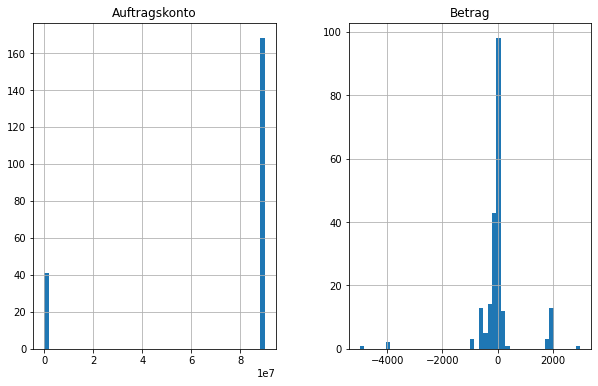

In [95]:
dataset.hist(bins=50, figsize=(10,6))

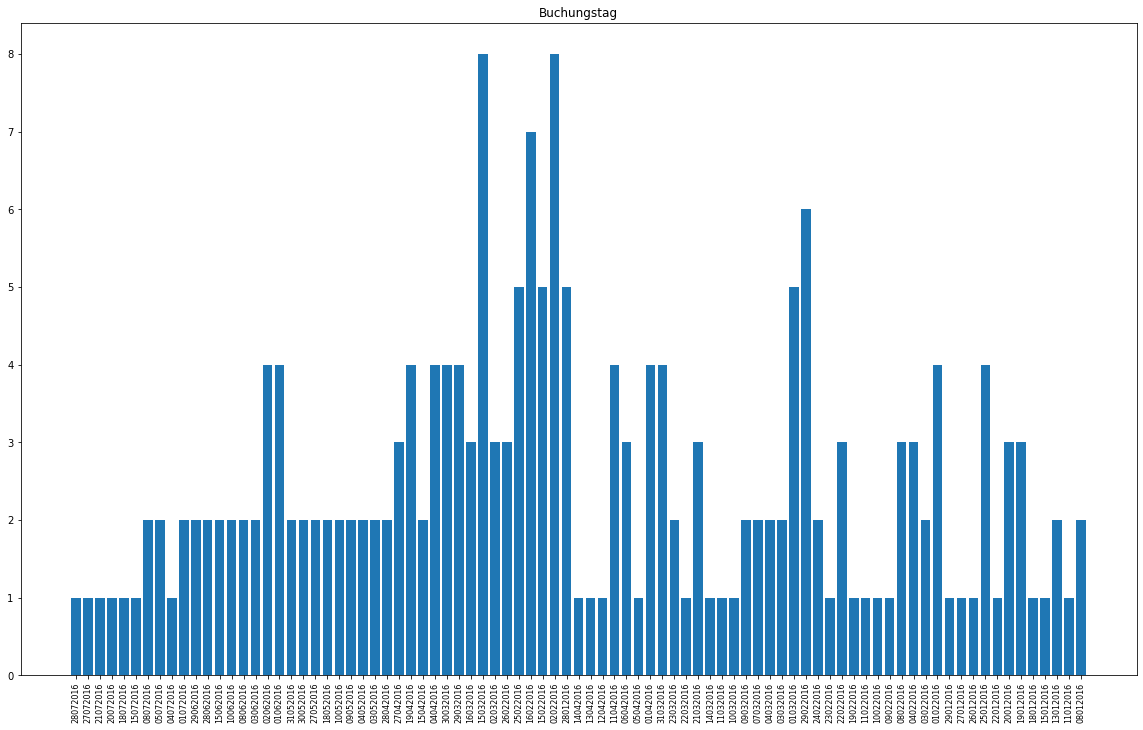

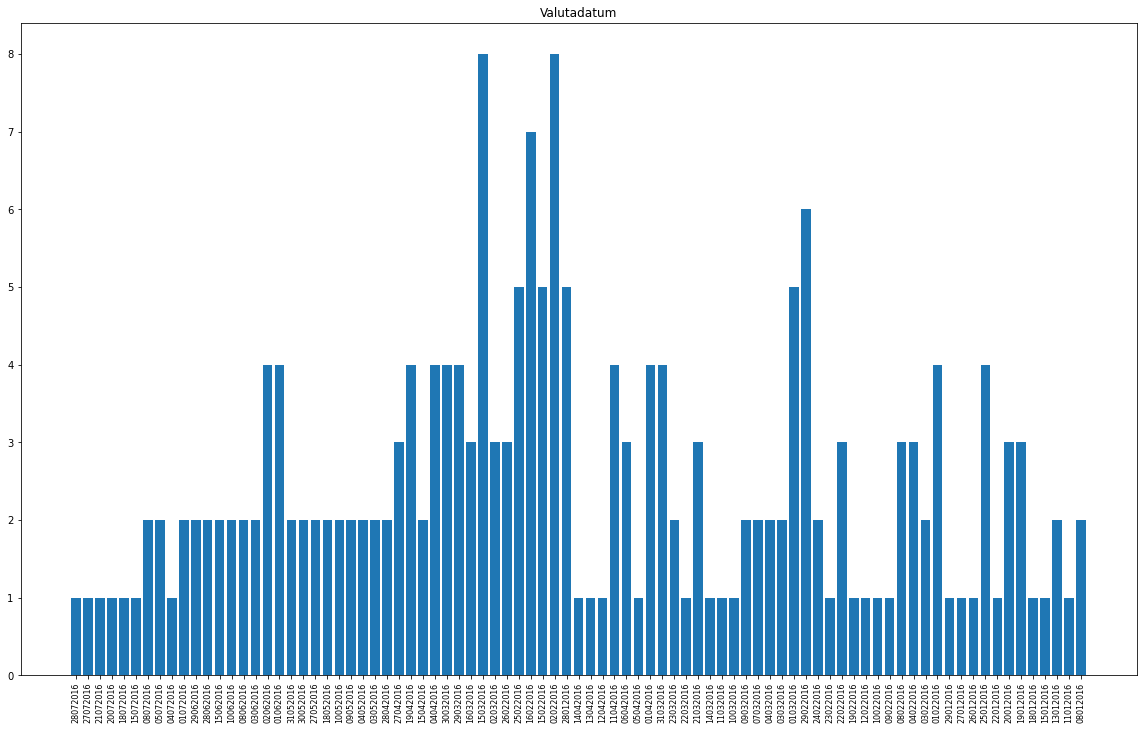

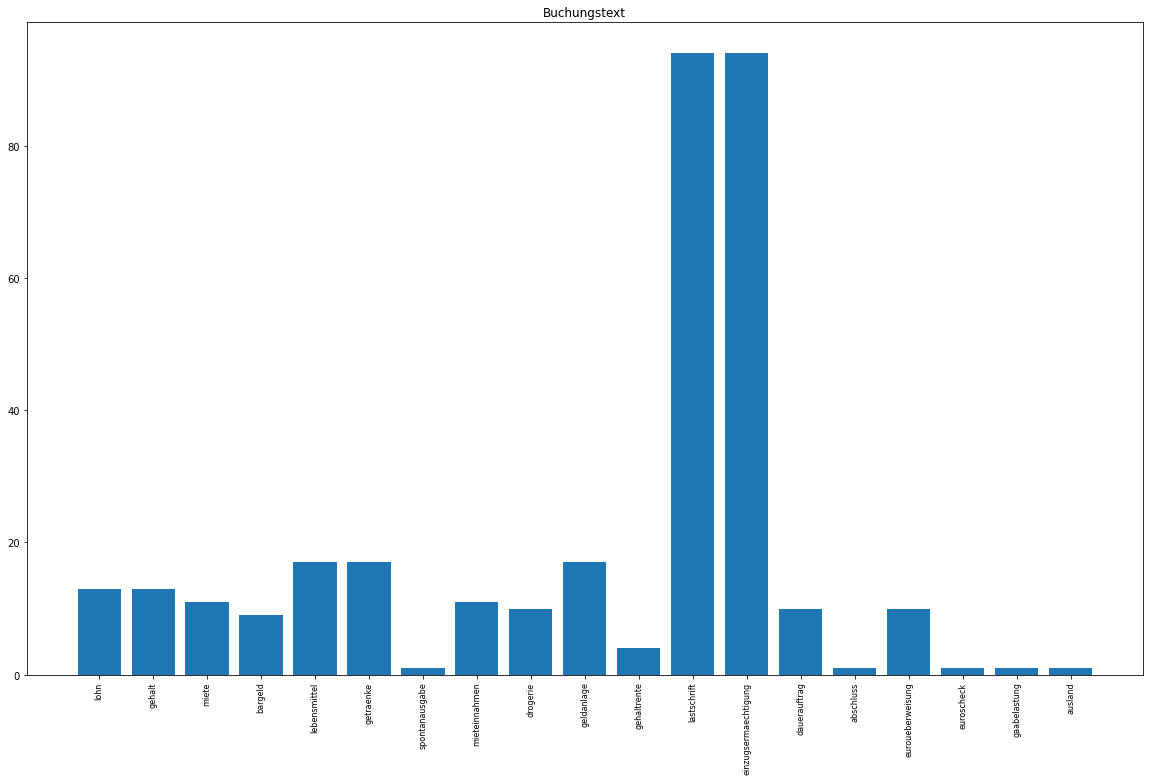

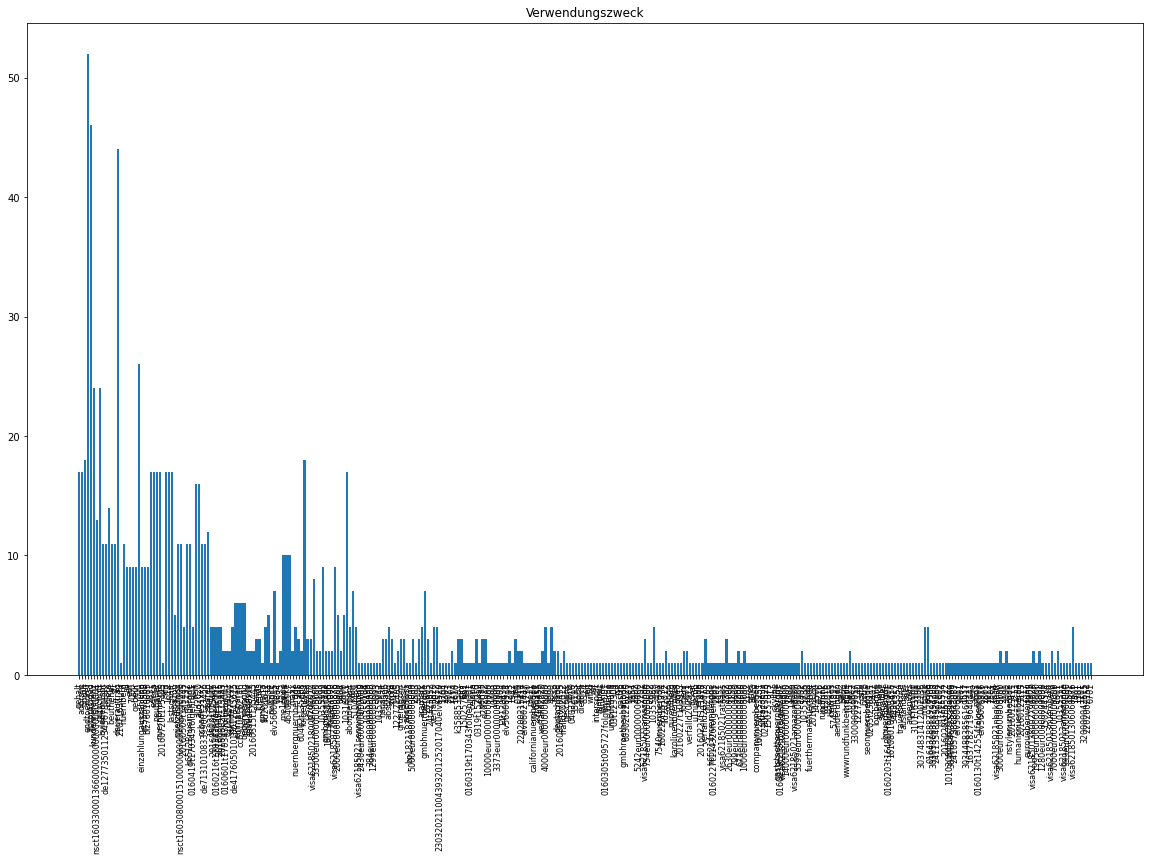

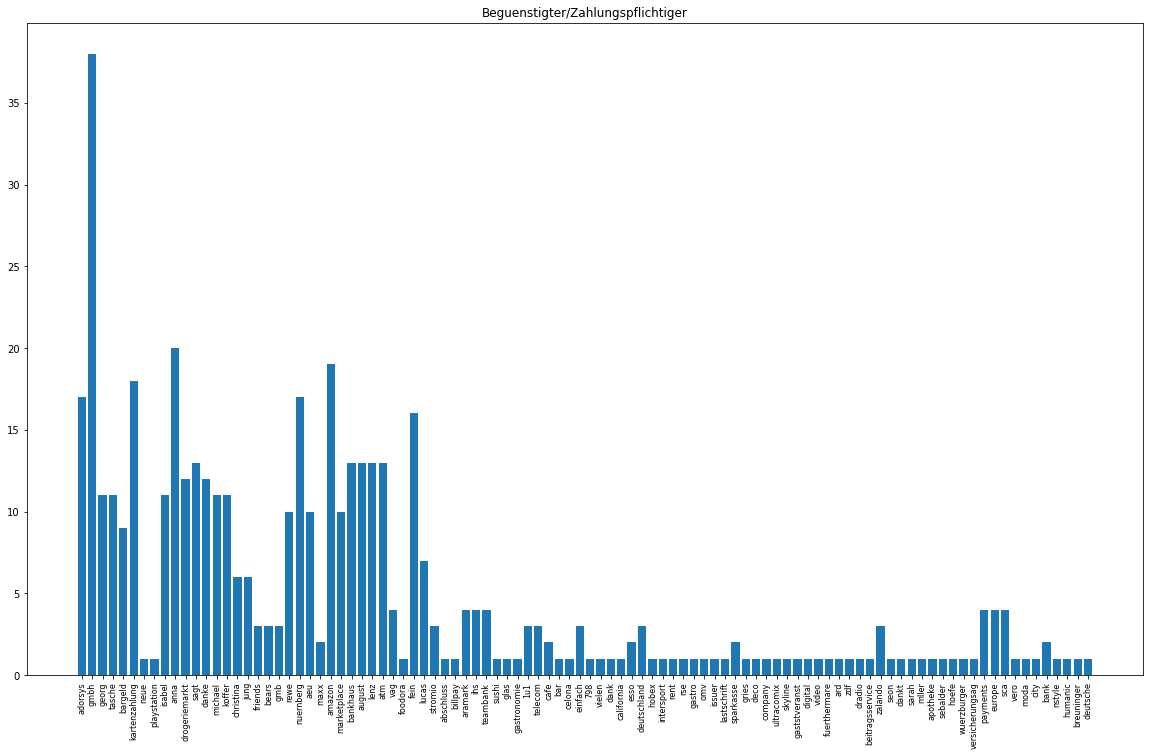

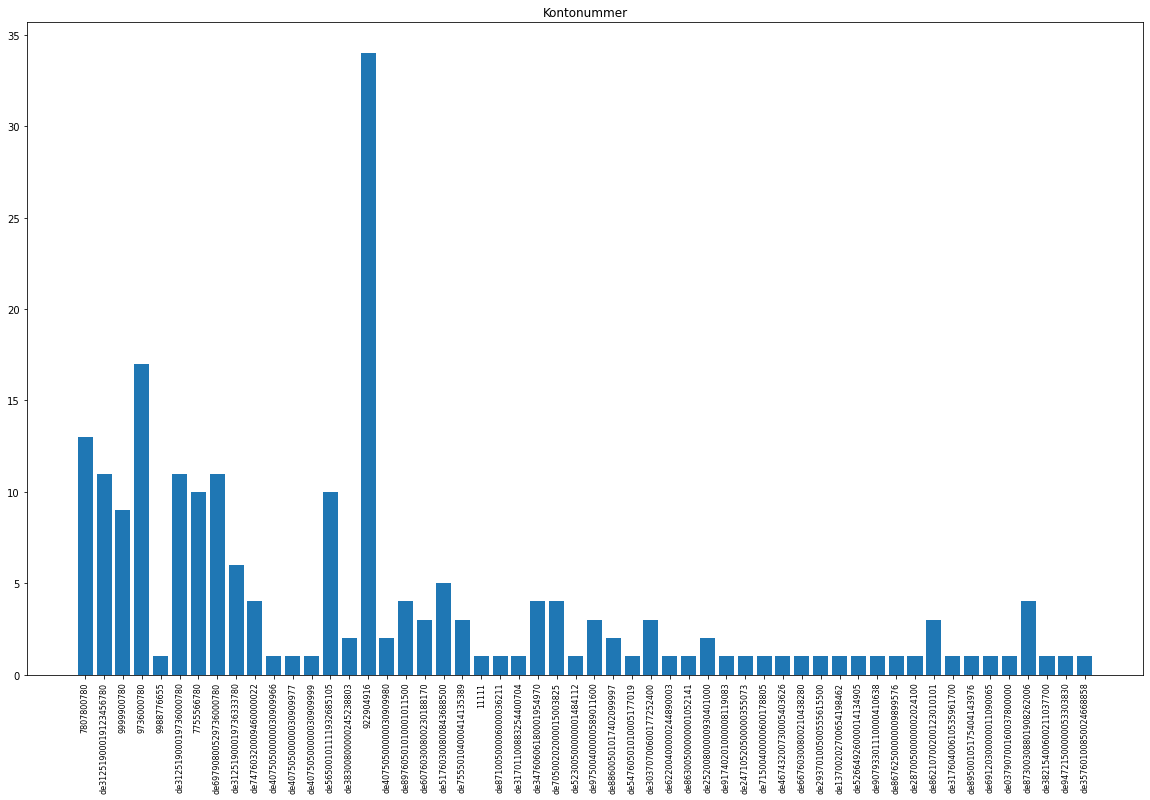

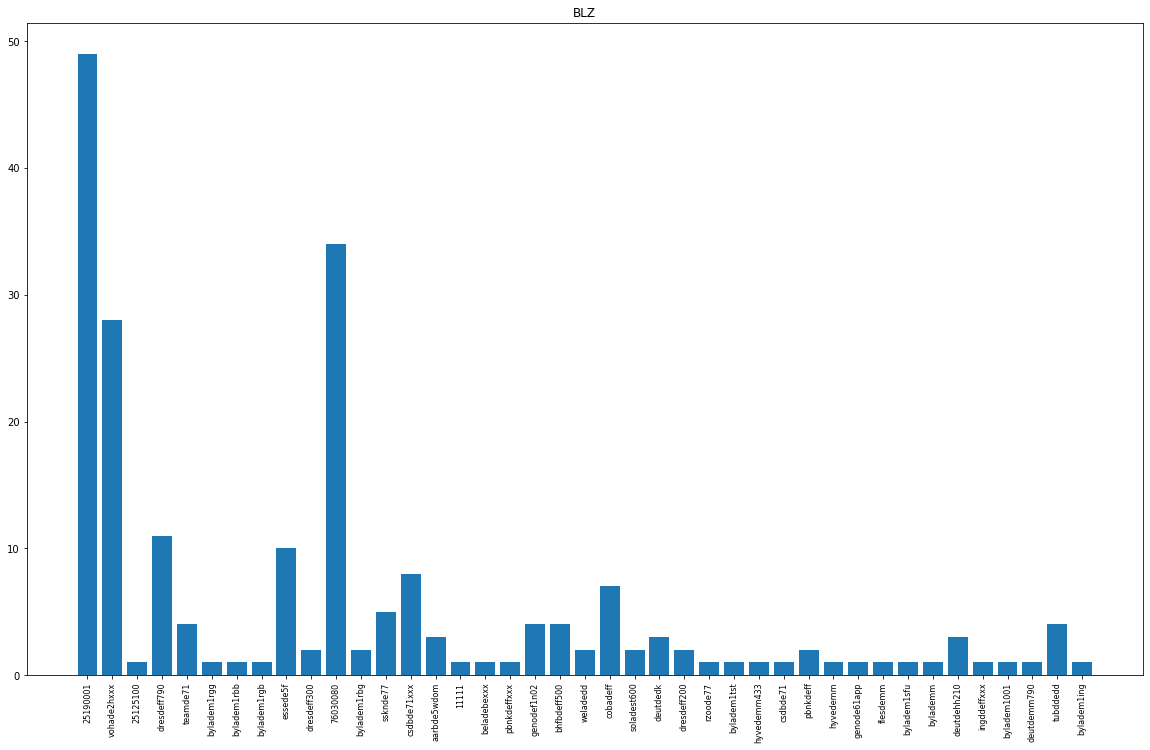

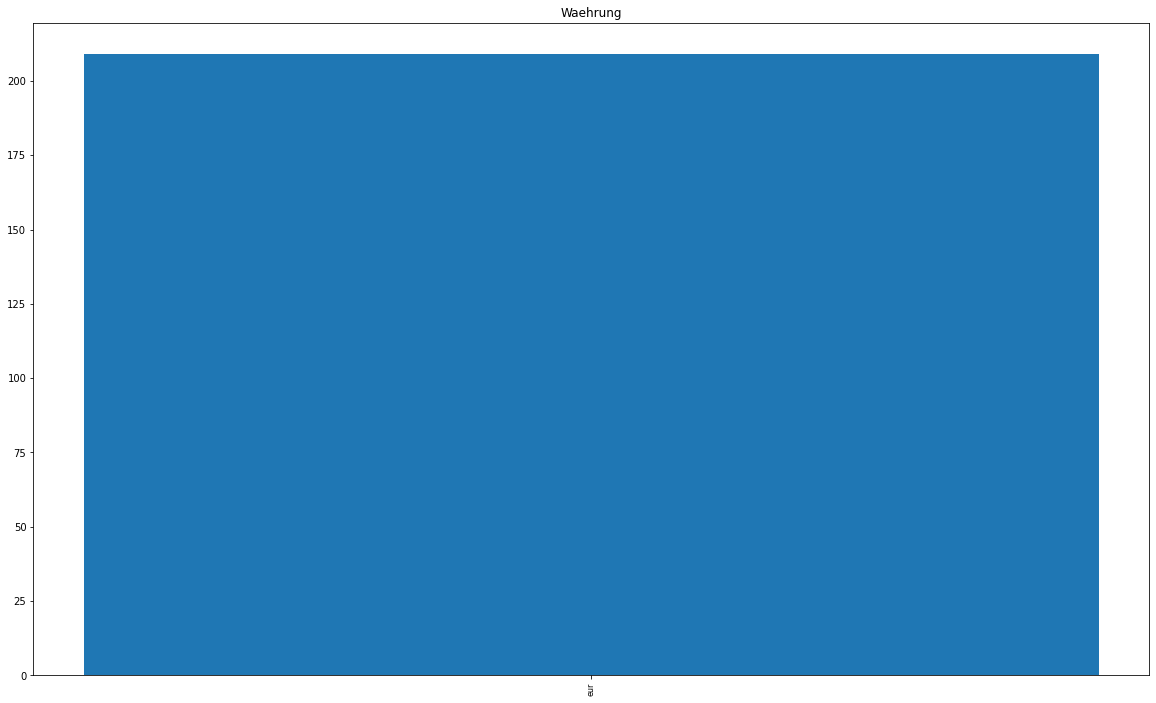

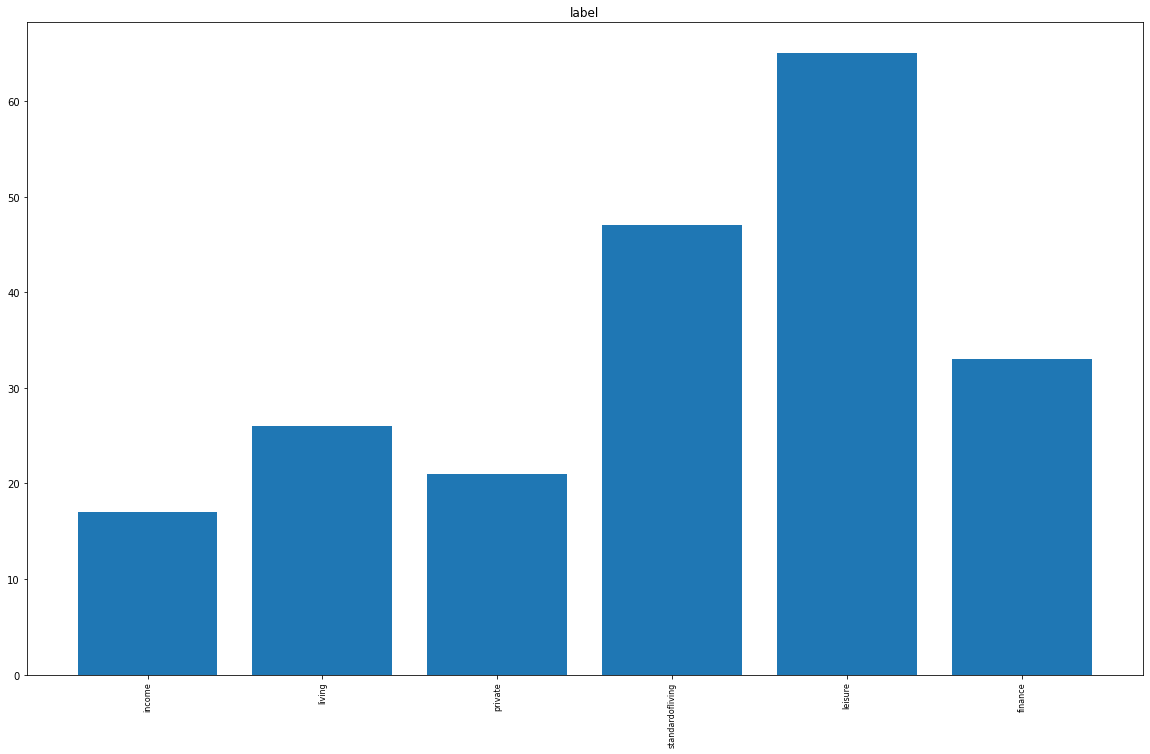

In [96]:
from collections import Counter

def plot_token_frequencies(data):
    plt.figure(num=None, figsize=(20, 12), facecolor='w', edgecolor='k')
    text_data = [token for i, text in enumerate(data) for token in text.split()]
    token_counts = Counter(text_data).values()
    tokens = Counter(text_data).keys()
    plt.bar(np.arange(len(tokens)), token_counts)
    plt.xticks(np.arange(len(tokens)), tokens, rotation="vertical", fontsize=8)
    
for text_data in dataset.select_dtypes(include=["object"]):
    plot_token_frequencies(dataset[text_data])
    plt.title(text_data)

### Prepare features / transform them into a working format

#### Features Vecture creation

In [97]:
def create_word_bag_and_dictionary(all_tokens):
    for token_line in all_tokens:
        for token in token_line:
            if token == '':
                continue
            if token not in word_bag_dictionary:
                word_bag.append(token)
                word_bag_dictionary[token] = len(word_bag) - 1

def vectorize_text(text, max_feats=125, transform = False):
    #Creae Bag of words from Text Field
    vectorizer =  CountVectorizer(max_features=max_feats)
    X = vectorizer.fit_transform(text).toarray()
    if transform: 
        X = TfidfTransformer.fit_transform(X).toarray()
    return X # pd.DataFrame(data= X , columns= vectorizer.get_feature_names())

In [110]:
#Create encoded labels as classes [0-5]
le = LabelEncoder()
y =  LabelEncoder().fit_transform(dataset['label'])
classses_labels = list(le)

AttributeError: 'LabelEncoder' object has no attribute 'classes_'

In [99]:
#Create Features form single Word text Fields
X_buchungstext = LabelEncoder().fit_transform(dataset['Buchungstext'])
X_beguenstigter = LabelEncoder().fit_transform(dataset['Beguenstigter/Zahlungspflichtiger'])

#Create Features from a Bag a words
X_Verwe = vectorize_text(dataset['Verwendungszweck'], max_feats=100)

#Normalize values to reduce the variance
X_num = MinMaxScaler(feature_range=(0, 1)).fit_transform(dataset[['Betrag']].values)

#Combine All features to create the matrix
X_matrix = np.concatenate((X_buchungstext.reshape(-1,1), X_beguenstigter.reshape(-1,1),  X_Verwe, X_num), axis = 1)


In [100]:
#select k best features
def k_best(x,y,k):
    selector = SelectKBest(chi2, k=k)
    x_new = selector.fit_transform(x,y)
    columns = selector.get_support(indices=True)
    new_columns = x.columns[columns]
    return pd.DataFrame(x_new,columns=new_columns)

## Train the Classifier Model

In [101]:
#Create Gaussian Naive Bayes classifier 
clasifier = GaussianNB()

In [102]:
# Splite in traing and testing
X_train, X_test, y_train, y_test = train_test_split(X_matrix, y, test_size=0.15)

In [103]:
#Train Classifier Model
clasifier.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [104]:
# Prediction
y_pred = clasifier.predict(X_test)
y_pred_prob = clasifier.predict_proba(X_test)

## Report Results

#### Evaluation - Confusion matrix

In [106]:
# Get accuracy Evaluation Metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      1.00      1.00         3
           2       0.78      0.70      0.74        10
           3       0.75      0.75      0.75         4
           4       0.40      1.00      0.57         2
           5       1.00      0.88      0.93         8

    accuracy                           0.81        32
   macro avg       0.82      0.85      0.81        32
weighted avg       0.86      0.81      0.83        32



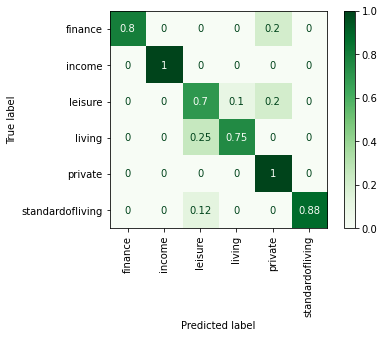

In [107]:
#Create Confusion Matrix
cm = confusion_matrix(y_test, y_pred, normalize= 'true')
# Display the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= np.unique( dataset['label']))
disp.plot(xticks_rotation= 'vertical', cmap =plt.cm.Greens)